In [189]:
using Random
using Plots
using Distributions
using DifferentialEquations

a = 1.0
v = 6*10^-4
M = 2 #This is the amount of genes we want in our network
Orbit_Plotting = true  #Currently not used yet
Epi_Plotting = true #Currently not used yet
Counter = 0 #Used to randomise the mutations later

SplitTime = 1.5 #Time before a splitting event happens
KArray = zeros(1,M) #Diffusion array is set to zero everywhere
#KArray[5] = 0 #Here we can manually adjust which genes will have diffusion

function Setting_Up_Randomly(M,rng=MersenneTwister(123))
    "Function used to randomly with seed define our c_i's, J_ij's and the initial positions
    Input:
    M   = Amount of Genes in our system
    rng = Random Julia seed to make sure we can recreate the same initial conditions
    Output:
    CArray          = C_i's used, can only be between -0.5 and 0.5 now
    PositionArray   = Random Initial position, between -1 and 1 for all genes, epifactors = 0
    ParameterMatrix = J_ij's Currently a dense network with values between -0.5 and 0.5
    "
    ParameterMatrix = zeros(M,M)
    CArray = zeros(1,M)
    PositionArray = zeros(1,2*M)
    
    CArray = rand(rng,M).-0.5; #Random c_j between -0,5 and 0.5
    PositionArray[1:M] = 2*(rand(rng,M).-0.5); #Random Initial position 
    ParameterMatrix = rand(rng,M,M).-0.5; #J_jk's  
    return CArray, PositionArray, ParameterMatrix
end

function Epigenetic_Evolution(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    if Splits == 0  #Cannot difuse
        for j=1:M*2^Splits #Gene evolution
            du[j] = tanh(40*(sum(ParameterMatrix[j,:].*u[1:M]/sqrt(M)) + u[j+M] + CArray[j])) - u[j] 
        end
    elseif Splits == 1   #Only diffusion with 1 neighbour, 2 cells in total
        #i=1 is the first cell
        for j=1:M
           du[j] = tanh(40*(sum(ParameterMatrix[j,:].*u[1:M]/sqrt(M)) + u[j+M*2^Splits] + CArray[j])) - u[j] + KArray[j]*(u[j+M] - u[j])
        end
        #i=2 is the second cell
        for j=1:M
           du[j+M] = tanh(40*(sum(ParameterMatrix[j,:].*u[M+1:2*M]/sqrt(M)) + u[j+M+M*2^Splits] + CArray[j])) - u[j+M] + KArray[j]*(u[j] - u[j+M])
        end
        else #Now we have 4 or more cells
        for i=0:2^Splits-1 #Loop over all cells, Can defuse but watch for boundaries (next if statement)
            if i==0 #Boundaries for diff.
                for j=1:M
                    du[j] = tanh(40*(sum(ParameterMatrix[j,:].*u[1:M]/sqrt(M)) + u[j+M*2^Splits] + CArray[j])) - u[j] + KArray[j]*(u[j+M] - u[j])
                end
        elseif i == 2^Splits-1 #Boundaries for diff.
                for j=1:M
                    du[j+M*i] = tanh(40*(sum(ParameterMatrix[j,:].*u[i*M+1:M*2^Splits]/sqrt(M)) + u[j+M*i+M*2^Splits] + CArray[j])) - u[j+M*i] + KArray[j]*(u[j+M*(i-1)] - u[j+M*i])
                end
            else # Free to diffuse in both directions
                for j=1:M
                    du[j+M*i] = tanh(40*(sum(ParameterMatrix[j,:].*u[M*i+1:M*(i+1)]/sqrt(M)) + u[j+M*i+M*2^Splits] + CArray[j])) - u[j+M*i] + KArray[j]*(u[j+M*(i-1)] - 2u[j+M*i] + u[j+M*(i+1)])
                end
            end                
    end
end
    
    for j=1:M*2^Splits #Epigenetic Evolution, no need to worry about boundaries here so simple loop
        du[M*2^Splits + j] = v*(a*u[j] - u[j+M*2^Splits])
        
    end
    
end

function Epigenetic_Evolution3(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    
    
    for i=0:2^Splits-1 #Loop over all cells, Can defuse but watch for boundaries (next if statement)
        for j=1:M
            du[j+M*i] = tanh(40*(sum(ParameterMatrix[j,:].*u[M*i+1:M*(i+1)]/sqrt(M)) + u[j+M*i+M*2^Splits] + CArray[j])) - u[j+M*i]
        end   
                      
    end

    
    for j=1:M*2^Splits #Epigenetic Evolution, no need to worry about boundaries here so simple loop
        du[M*2^Splits + j] = v*(a*u[j] - u[j+M*2^Splits])
        
    end
    
end

function Epigenetic_Evolution2(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    for i=0:2^Splits-1 #Loop over all cells
        #print(length(ParameterMatrix[1:M,:]))
        #print("a")
        #print(length(u[M*i+1:M*(i+1)]))
        #print("b")
        #print(length(u[M*i+M*2^Splits + 1:M+M*i+M*2^Splits]))
        #print("c")
        #print(length(u[M*i+1:M+M*i]))
        #print("d")
        du[M*i+1:M+M*i] = tanh.(40*(sum(ParameterMatrix[1:M,:].*u[M*i+1:M*(i+1)]/sqrt(M)) .+ u[M*i+M*2^Splits + 1:M+M*i+M*2^Splits] .+ CArray[1:M])) .- u[M*i+1:M+M*i]                
    end
    

    
    #Epigenetic Evolution, no need to worry about boundaries here so simple loop
    du[M*2^Splits + 2^Splits*1:M*2^Splits+M*2^Splits ] = v*(a*u[2^Splits*1:M*2^Splits] .- u[M*2^Splits+2^Splits*1:M*2^Splits+M*2^Splits])
    return du
end


function Noisy_Splitting(solution,Total_Splits,M,Seed)
    " Once our cell decides to split, we decide to introduce some random noise in how these genes get distributed.
    This function takes the cells, doubles them and then gives the daughters cell the same gene parameters +- noise
    one daughter gets + the other gets -. For the epigeneitc factors they are simply inherited and do not see any noise
    Input:
    solution     = These are the initial conditions of the parent cells that we need to split 
    (First genes of all cells, then all epigenetic factors)
    Total_Splits = Amount of times the cell has split (including this current split)
    M            = Amount of Genes
    Seed         = Random Noise seed for reproducing results
    Output:
    SplittedArray = New array of the genes and epigenetic factors of the daughter cells
    How is this structured? Suppose we take M=3 for convenience, we would have [g1,g2,g3,e1,e2,e3] for the first parent cell
    The daughters become: [g11,g12,g13,g21,g22,g23,e11,e12,e13,e21,e22,e23]
    Where we have genes of daughter 1, then genes of daughter 2, then epi of daughter 1 and epi of daughter 2.
    When the Daughters split we get the genes of Children of cell 1, then genes of Children of cell 2 and same for epi.
    "
    Random.seed!(Seed)
    s = Total_Splits #For shortening
    
    SplittedArray = zeros(1,2^(s+1)*M) #2^(s+1), 2M is the normal length, 4M after 1 split, 8M after 2 splits etc.
    for g=1:2^(s-1)*M #looping over the length of the parent
        Gaussian = Normal(0.0,0.05)
        Displace = rand(Gaussian) #Noise for split
        index = Int.(floor((g-1)/M)*M +g) #example M=10: Index 1-> 1 and 11, index 2->2 and 12 ... 
        #index 10->10 and 20, index 11->21 and 30 and so on. 

        #Genes
        SplittedArray[index] = solution[g] + Displace
        SplittedArray[index+M] = solution[g] - Displace
        
        #Epigenetic
        SplittedArray[index + 2^(s)*M] = solution[g + 2^(s-1)*M]
        SplittedArray[index+M + 2^(s)*M] = solution[g + 2^(s-1)*M]   
    end
    return SplittedArray  
end

function Differentiaton_Detection_Parameter(M,Epigenetic_Plot)
    Diff_Parameter = zeros(M)
    Jump_Parameter = zeros(M)
    
    for i=1:Int.(length(Epigenetic_Plot[:,1]))
        for j=1:M
            if abs(Epigenetic_Plot[i,j]) < 0.75
                Diff_Parameter[j] += 1
            end
            #Note that a triple size would be +0.5 + 1.0 + 1.5 because all 3 would be added
            if i>1 #Single_Size_Jump
                if sign(Epigenetic_Plot[i,j])!=sign(Epigenetic_Plot[i-1,j])
                    Jump_Parameter[j] += 0.5
                end
            end
            if i>3 #Double_Size_Jump
                if sign(Epigenetic_Plot[i-3,j])==sign(Epigenetic_Plot[i-2,j]) && sign(Epigenetic_Plot[i-1,j])==sign(Epigenetic_Plot[i,j]) && sign(Epigenetic_Plot[i-2,j])!=sign(Epigenetic_Plot[i-1,j])
                    Jump_Parameter[j] += 0.5*2
                end
            end
            if i>5 #Triple_Size_Jump
                if sign(Epigenetic_Plot[i-5,j])==sign(Epigenetic_Plot[i-4,j])==sign(Epigenetic_Plot[i-3,j]) && sign(Epigenetic_Plot[i-2,j])==sign(Epigenetic_Plot[i-1,j])==sign(Epigenetic_Plot[i,j]) && sign(Epigenetic_Plot[i-3,j])!=sign(Epigenetic_Plot[i-2,j])
                    Jump_Parameter[j] += 0.5*3
                end
            end
        end
    end
    
    #Check for head/tail differentiaion
    #If error, it may be because Epigenetic_Plot was too small (I assume at least size 12)
    for j=1:M
       Head_Tail = true
        for k=1:5
            if sign(Epigenetic_Plot[k,j])!=sign(Epigenetic_Plot[k+1,j])
                Head_Tail = false
            end
            if sign(Epigenetic_Plot[2^Splits+1-k,j])!=sign(Epigenetic_Plot[2^Splits-k,j]) 
                Head_Tail = false
            end
        end
        if sign(Epigenetic_Plot[2,j])==sign(Epigenetic_Plot[2^Splits-2,j])
            Head_Tail = false
        end
        if Head_Tail
            Diff_Parameter[j] += Head_Tail_Bonus
        end 
    end
    
    return Diff_Parameter, Jump_Parameter
end


function Mutate_Parameters(ParameterMatrix,M,Mutations,Seed)
    
    Random.seed!(Seed)
    for j=1:Mutations #Risk of remutating the same connection is roughly (Mutations-1)/M² (2% for M=10, Mutations = 3)
        ParameterMatrix[rand(1:M),rand(1:M)] = rand().-0.5
    end
    return ParameterMatrix
end


Mutate_Parameters (generic function with 1 method)

3×2 Matrix{Int64}:
   2    6
 100  126
 360  410

In [190]:
N=8
K=4
Splits = 5 #How often will we split
CArray_Collection = zeros(N,M)
PositionArray_Collection = zeros(N,2*M)
ParameterMatrix_Collection = zeros(N,M,M)
Final_Epigenetic_Factors = zeros(N,2^Splits,M)
for i=1:N
    RandomInitial = 1000*i+5 #Seed for Initial conditions

    CArray_Collection[i,:], PositionArray_Collection[i,:], ParameterMatrix_Collection[i,:,:] = Setting_Up_Randomly(M,MersenneTwister(RandomInitial))
    #Sets the initial conditions that we will be reusing in the simulation (Change RandomInitial for different values)
    
end


Random_Noise = 574 #seed for splitting noise

#Need to define outside for loop, otherwise it will be destroyed afterwards
Times = 0
Genes = 0

0

In [191]:
du = [0.1,0,0,0]
u1 = [0.4,0.7,0.1,0.2]
u2 = [0.4,0.7,0.1,0.2]
ParameterMatrix = [2 3; 4 5]
CArray = [0.3, 0.1]
s = 1

Parameters = (ParameterMatrix, CArray,KArray,s-1)
Time = (0.0,0.1)
du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)

print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1


du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1

du1 = Epigenetic_Evolution(du,u1,Parameters,Time)
du2 = Epigenetic_Evolution2(du,u2,Parameters,Time)
print(du1)

print("test")
print(du2)
u1 = u1 + du1*0.1
u2 = u2 + du2*0.1


nothingtest[0.6, 0.30000000000000004, 0.00018000000000000004, 0.0003]

LoadError: MethodError: no method matching *(::Nothing, ::Float64)
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:385
[0m  *([91m::StridedArray{P}[39m, ::Real) where P<:Dates.Period at D:\Julia-1.8.5\share\julia\stdlib\v1.8\Dates\src\deprecated.jl:44
[0m  ...

In [192]:
using ProgressMeter
using TickTock
tick()
blabla = 1
Orbit1 = 0
Orbit2 = 0
Orbit3 = 0
Orbit4 = 0
Orbit5 = 0
EpiOrbit1 = 0
EpiOrbit2 = 0
EpiOrbit3 = 0
EpiOrbit4 = 0
EpiOrbit5 = 0
FinalOrbit = 0
FinalEpiOrbit = []
@showprogress 1 "Networks" for x=1:N
    CArray = CArray_Collection[x,:]
    ParameterMatrix = ParameterMatrix_Collection[x,:,:]
    PositionArray = PositionArray_Collection[x,:]
    for s=1:Splits #Looping over the splits
        Parameters = (ParameterMatrix, CArray,KArray,s-1) #We have to update the splits every rerun, rest stays same
        tspan = (0.0,SplitTime) #How long ODE will run
        prob = ODEProblem(Epigenetic_Evolution3,PositionArray,tspan,Parameters) #ODEdefining
        #sol = solve(prob,abstol=1e-5) #Solving
        sol = solve(prob) #Solving
        Times = sol.t #Save the time, doesn't get used yet though
        StepAmount = length(Times)  #Amount of data points per gene
        Genes = sol 
        PositionArray = Genes[StepAmount] #Saving the genes and epi factors

        #Now we must take all the values from the updated PositionArray and give appropriate terms to the daughter cells
        PositionArray = Noisy_Splitting(PositionArray,s,M,Random_Noise)  #Splitting function
        if x==blabla
            if s==1
                Orbit1 = [Times,Genes[1:M,1:StepAmount]]
                EpiOrbit1 = [Times,Genes[M+1:2*M,1:StepAmount]]
            elseif s==2
                Orbit2 = [Times.+SplitTime,Genes[1,1:M*2,1:StepAmount]]
                EpiOrbit2 = [Times,Genes[1,2*M+1:2^2*M,1:StepAmount]]
            elseif s==3
                Orbit3 = [Times.+SplitTime*2,Genes[1,1:M*2^2,1:StepAmount]]
                 EpiOrbit3 = [Times,Genes[1,M*2^2+1:2^3*M,1:StepAmount]]

            elseif s==4
                Orbit4 = [Times.+SplitTime*3,Genes[1,1:M*2^3,1:StepAmount]]
                EpiOrbit4 = [Times,Genes[1,M*2^3+1:2^4*M,1:StepAmount]]

            elseif s==5
                Orbit5 = [Times.+SplitTime*4,Genes[1,1:M*2^4,1:StepAmount,]]
                EpiOrbit5 = [Times,Genes[1,M*2^4+1:2^5*M,1:StepAmount]]

            else
                print("Error, add more orbittracker")
                break
            end
        end

        #Now we rerun and keep splitting
    end

    Final_Run_Time = 5000 #Long evolving of the cells after splitting to get the final epigenetic state
    Parameters = (ParameterMatrix, CArray,KArray,Splits) 
    tspan = (0.0,Final_Run_Time)

    prob = ODEProblem(Epigenetic_Evolution3,PositionArray,tspan,Parameters) #ODEdefining
    sol = solve(prob) #Solving
    #sol = solve(prob,abstol=1e-4)
    Times = sol.t
    StepAmount = length(Times)
    GenesEpi = sol
    PositionArray = GenesEpi[StepAmount]
    Genes = PositionArray[1:2^Splits*M] #Saves all the final genes
    Epigenetic = PositionArray[1+2^Splits*M:2^(Splits+1)*M]; #Saves all the final Epigenetic factors
    if x==blabla
        FinalOrbit = [Times,GenesEpi[1,1:M*2^5,1:StepAmount]]
        FinalEpiOrbit = GenesEpi[1,M*2^5+1:M*2^6,1:StepAmount]
    end
    Epigenetic_Plot = zeros(Int.(length(Epigenetic)/M),M)
    for l=1:M
        
        Epigenetic_Plot[:,l] = Epigenetic[l:M:end]  #Reshapes the factors to plot easily    
    end
    
    Final_Epigenetic_Factors[x,:,:] = Epigenetic_Plot
    
end
print("Jobs Done")
tock()

[ Info:  started timer at: 2023-05-15T11:22:33.488


LoadError: MethodError: no method matching +(::Float64, ::Vector{Float64})
For element-wise addition, use broadcasting with dot syntax: scalar .+ array
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  +(::T, [91m::T[39m) where T<:Union{Float16, Float32, Float64} at float.jl:383
[0m  +(::Union{Float16, Float32, Float64}, [91m::BigFloat[39m) at mpfr.jl:414
[0m  ...

In [193]:
if Orbit_Plotting
    GeneTimes = cat(Orbit1[1],Orbit2[1],Orbit3[1],Orbit4[1],Orbit5[1],dims=1)
    GeneEvolution = zeros(M*2^(Splits),length(GeneTimes),2)
    Length = 0
    for s=1:5  
        if s==1
            for i=1:M
                Length = length(Orbit1[2][i,:])
                for j=1:2^(Splits)  
                    GeneEvolution[i+M*(j-1),1:Length,1] = Orbit1[2][i,:]
                    GeneEvolution[i+M*(j-1),1:Length,2] = EpiOrbit1[2][i,:]
                end
            end

        elseif s==2
            for i=1:2*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+2*M*(j-1),Length+1:Length + length(Orbit2[2][i,:]),1] = Orbit2[2][i,:]
                    GeneEvolution[i+2*M*(j-1),Length+1:Length + length(Orbit2[2][i,:]),2] = EpiOrbit2[2][i,:]

                end
            end
            Length = Length + length(Orbit2[2][1,:])
        elseif s==3
            for i=1:4*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+4*M*(j-1),Length+1:Length + length(Orbit3[2][i,:]),1] = Orbit3[2][i,:]
                    GeneEvolution[i+4*M*(j-1),Length+1:Length + length(Orbit3[2][i,:]),2] = EpiOrbit3[2][i,:]
                end
            end
            Length = Length + length(Orbit3[2][1,:])

        elseif s==4
            for i=1:8*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+8*M*(j-1),Length+1:Length + length(Orbit4[2][i,:]),1] = Orbit4[2][i,:]
                    GeneEvolution[i+8*M*(j-1),Length+1:Length + length(Orbit4[2][i,:]),2] = EpiOrbit4[2][i,:]

                end
            end
            Length = Length + length(Orbit4[2][1,:])
        else
            for i=1:16*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+16*M*(j-1),Length+1:Length + length(Orbit5[2][i,:]),1] = Orbit5[2][i,:]
                    GeneEvolution[i+16*M*(j-1),Length+1:Length + length(Orbit5[2][i,:]),2] = EpiOrbit5[2][i,:]
                end
            end
        end
    end
    j=1
    pa = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pa = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=2
    pb = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pb = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=1
    pc = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pc = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=2
    pd = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pd = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    k = plot(pa,pb,pc,pd,layout=(4,1),legend=false)
    
end

LoadError: BoundsError

In [186]:
N=8
K=4
Splits = 5 #How often will we split
CArray_Collection = zeros(N,M)
PositionArray_Collection = zeros(N,2*M)
ParameterMatrix_Collection = zeros(N,M,M)
Final_Epigenetic_Factors = zeros(N,2^Splits,M)
for i=1:N
    RandomInitial = 1000*i+5 #Seed for Initial conditions

    CArray_Collection[i,:], PositionArray_Collection[i,:], ParameterMatrix_Collection[i,:,:] = Setting_Up_Randomly(M,MersenneTwister(RandomInitial))
    #Sets the initial conditions that we will be reusing in the simulation (Change RandomInitial for different values)
    
end


Random_Noise = 574 #seed for splitting noise

#Need to define outside for loop, otherwise it will be destroyed afterwards
Times = 0
Genes = 0

0

In [187]:
using ProgressMeter
using TickTock
tick()
blabla = 1
Orbit1 = 0
Orbit2 = 0
Orbit3 = 0
Orbit4 = 0
Orbit5 = 0
EpiOrbit1 = 0
EpiOrbit2 = 0
EpiOrbit3 = 0
EpiOrbit4 = 0
EpiOrbit5 = 0
FinalOrbit = 0
FinalEpiOrbit = []
@showprogress 1 "Networks" for x=1:N
    CArray = CArray_Collection[x,:]
    ParameterMatrix = ParameterMatrix_Collection[x,:,:]
    PositionArray = PositionArray_Collection[x,:]
    for s=1:Splits #Looping over the splits
        Parameters = (ParameterMatrix, CArray,KArray,s-1) #We have to update the splits every rerun, rest stays same
        tspan = (0.0,SplitTime) #How long ODE will run
        prob = ODEProblem(Epigenetic_Evolution,PositionArray,tspan,Parameters) #ODEdefining
        #sol = solve(prob,abstol=1e-5) #Solving
        sol = solve(prob) #Solving
        Times = sol.t #Save the time, doesn't get used yet though
        StepAmount = length(Times)  #Amount of data points per gene
        Genes = sol 
        PositionArray = Genes[StepAmount] #Saving the genes and epi factors

        #Now we must take all the values from the updated PositionArray and give appropriate terms to the daughter cells
        PositionArray = Noisy_Splitting(PositionArray,s,M,Random_Noise)  #Splitting function
        if x==blabla
            if s==1
                Orbit1 = [Times,Genes[1:M,1:StepAmount]]
                EpiOrbit1 = [Times,Genes[M+1:2*M,1:StepAmount]]
            elseif s==2
                Orbit2 = [Times.+SplitTime,Genes[1,1:M*2,1:StepAmount]]
                EpiOrbit2 = [Times,Genes[1,2*M+1:2^2*M,1:StepAmount]]
            elseif s==3
                Orbit3 = [Times.+SplitTime*2,Genes[1,1:M*2^2,1:StepAmount]]
                 EpiOrbit3 = [Times,Genes[1,M*2^2+1:2^3*M,1:StepAmount]]

            elseif s==4
                Orbit4 = [Times.+SplitTime*3,Genes[1,1:M*2^3,1:StepAmount]]
                EpiOrbit4 = [Times,Genes[1,M*2^3+1:2^4*M,1:StepAmount]]

            elseif s==5
                Orbit5 = [Times.+SplitTime*4,Genes[1,1:M*2^4,1:StepAmount,]]
                EpiOrbit5 = [Times,Genes[1,M*2^4+1:2^5*M,1:StepAmount]]

            else
                print("Error, add more orbittracker")
                break
            end
        end

        #Now we rerun and keep splitting
    end

    Final_Run_Time = 5000 #Long evolving of the cells after splitting to get the final epigenetic state
    Parameters = (ParameterMatrix, CArray,KArray,Splits) 
    tspan = (0.0,Final_Run_Time)

    prob = ODEProblem(Epigenetic_Evolution,PositionArray,tspan,Parameters) #ODEdefining
    sol = solve(prob) #Solving
    #sol = solve(prob,abstol=1e-4)
    Times = sol.t
    StepAmount = length(Times)
    GenesEpi = sol
    PositionArray = GenesEpi[StepAmount]
    Genes = PositionArray[1:2^Splits*M] #Saves all the final genes
    Epigenetic = PositionArray[1+2^Splits*M:2^(Splits+1)*M]; #Saves all the final Epigenetic factors
    if x==blabla
        FinalOrbit = [Times,GenesEpi[1,1:M*2^5,1:StepAmount]]
        FinalEpiOrbit = GenesEpi[1,M*2^5+1:M*2^6,1:StepAmount]
    end
    Epigenetic_Plot = zeros(Int.(length(Epigenetic)/M),M)
    for l=1:M
        
        Epigenetic_Plot[:,l] = Epigenetic[l:M:end]  #Reshapes the factors to plot easily    
    end
    
    Final_Epigenetic_Factors[x,:,:] = Epigenetic_Plot
    
end
print("Jobs Done")
tock()

[ Info:  started timer at: 2023-05-15T11:17:20.753
Networks 100%|███████████████████████████████████████████| Time: 0:00:02


Jobs Done

[ Info:            2.4704307s: 2 seconds, 470 milliseconds


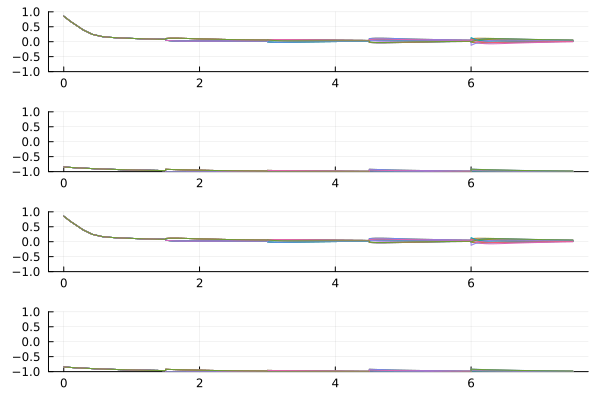

In [188]:
if Orbit_Plotting
    GeneTimes = cat(Orbit1[1],Orbit2[1],Orbit3[1],Orbit4[1],Orbit5[1],dims=1)
    GeneEvolution = zeros(M*2^(Splits),length(GeneTimes),2)
    Length = 0
    for s=1:5  
        if s==1
            for i=1:M
                Length = length(Orbit1[2][i,:])
                for j=1:2^(Splits)  
                    GeneEvolution[i+M*(j-1),1:Length,1] = Orbit1[2][i,:]
                    GeneEvolution[i+M*(j-1),1:Length,2] = EpiOrbit1[2][i,:]
                end
            end

        elseif s==2
            for i=1:2*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+2*M*(j-1),Length+1:Length + length(Orbit2[2][i,:]),1] = Orbit2[2][i,:]
                    GeneEvolution[i+2*M*(j-1),Length+1:Length + length(Orbit2[2][i,:]),2] = EpiOrbit2[2][i,:]

                end
            end
            Length = Length + length(Orbit2[2][1,:])
        elseif s==3
            for i=1:4*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+4*M*(j-1),Length+1:Length + length(Orbit3[2][i,:]),1] = Orbit3[2][i,:]
                    GeneEvolution[i+4*M*(j-1),Length+1:Length + length(Orbit3[2][i,:]),2] = EpiOrbit3[2][i,:]
                end
            end
            Length = Length + length(Orbit3[2][1,:])

        elseif s==4
            for i=1:8*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+8*M*(j-1),Length+1:Length + length(Orbit4[2][i,:]),1] = Orbit4[2][i,:]
                    GeneEvolution[i+8*M*(j-1),Length+1:Length + length(Orbit4[2][i,:]),2] = EpiOrbit4[2][i,:]

                end
            end
            Length = Length + length(Orbit4[2][1,:])
        else
            for i=1:16*M
                for j=1:2^(Splits-s+1)
                    GeneEvolution[i+16*M*(j-1),Length+1:Length + length(Orbit5[2][i,:]),1] = Orbit5[2][i,:]
                    GeneEvolution[i+16*M*(j-1),Length+1:Length + length(Orbit5[2][i,:]),2] = EpiOrbit5[2][i,:]
                end
            end
        end
    end
    j=1
    pa = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pa = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=2
    pb = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pb = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=1
    pc = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pc = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    j=2
    pd = plot(GeneTimes,GeneEvolution[j,:,1]) 
    for i=1:2^(Splits-1)-1
      pd = plot!(GeneTimes,GeneEvolution[j+M*i,:,1]) 
    end
    ylims!(-1, 1)
    k = plot(pa,pb,pc,pd,layout=(4,1),legend=false)
    
end

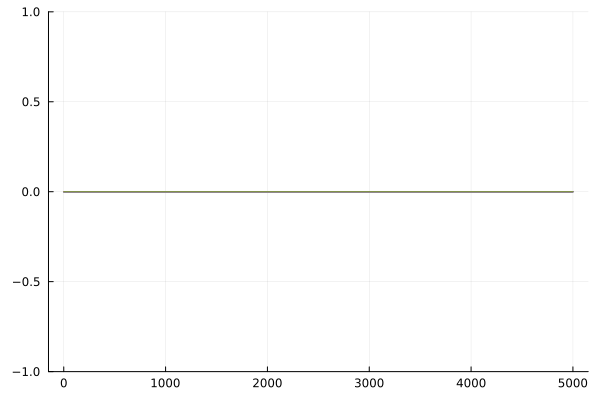

In [93]:
temporary = plot(Times,FinalEpiOrbit[1,1:34]) 
for i=1:2^(Splits-1)-1
  temporary = plot!(Times,FinalEpiOrbit[i,1:34]) 
end
ylims!(-1, 1)
plot(temporary,legend=false)

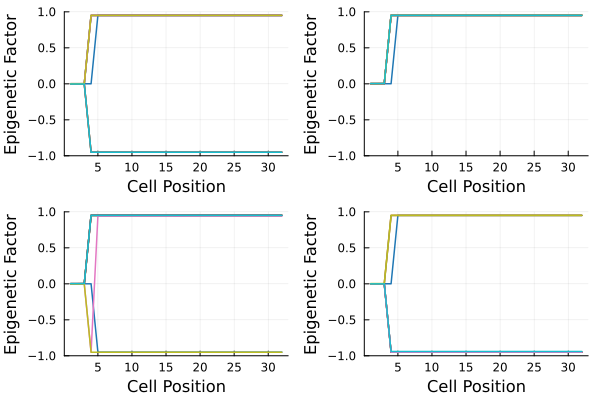

In [17]:
k=0
pa = plot(Final_Epigenetic_Factors[4*k+1,:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic Factor")
ylims!(-1, 1)

pb = plot(Final_Epigenetic_Factors[4*k+2,:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic Factor")
ylims!(-1, 1)

pc = plot(Final_Epigenetic_Factors[4*k+3,:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic Factor")
ylims!(-1, 1)

pd = plot(Final_Epigenetic_Factors[4*k+4,:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic Factor")
ylims!(-1, 1)

k = plot(pa,pb,pc,pd,layout=(2,2),legend=false)

In [18]:
Scoring = zeros(2,N)
Diffuse_Weight = 0.1 #Can change how we are fitting and selecting our network
Head_Tail_Bonus = 10
for x=1:N
    Diffuse,Jump = Differentiaton_Detection_Parameter(M,Final_Epigenetic_Factors[x,:,:]) 
    DiffuseScore = sum(Diffuse)
    JumpScore = sum(Jump)
    
    Scoring[:,x] = [JumpScore + Diffuse_Weight*DiffuseScore,x]
end
print(Scoring)

[3.1 3.1 9.1 3.1 3.1 3.1 45.1 3.1; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0]

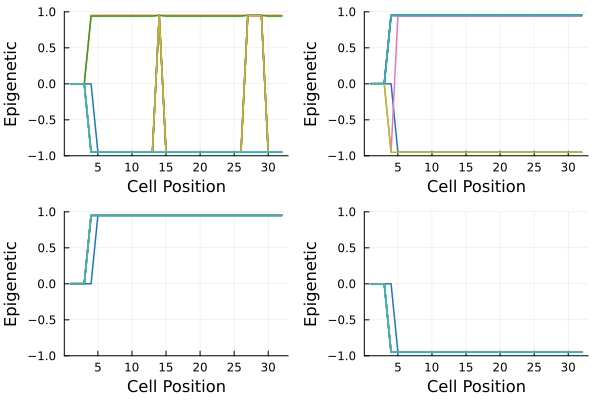

In [19]:
Indices = sortslices(Scoring,dims=2,rev=true)
#print(Indices[2,1:K])
Indices = Indices[2,1:K]
Indices = Int.(Indices)
pa = plot(Final_Epigenetic_Factors[Indices[1],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic")
ylims!(-1, 1)

pb = plot(Final_Epigenetic_Factors[Indices[2],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic")
ylims!(-1, 1)

pc = plot(Final_Epigenetic_Factors[Indices[3],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic")
ylims!(-1, 1)

pd = plot(Final_Epigenetic_Factors[Indices[4],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
xlabel!("Cell Position")
ylabel!("Epigenetic")
ylims!(-1, 1)

if K==8
    pe = plot(Final_Epigenetic_Factors[Indices[5],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pf = plot(Final_Epigenetic_Factors[Indices[6],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pg = plot(Final_Epigenetic_Factors[Indices[7],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    ph = plot(Final_Epigenetic_Factors[Indices[8],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    k = plot(pa,pb,pc,pd,pe,pf,pg,ph,layout=(4,2),legend=false)
else
    k = plot(pa,pb,pc,pd,layout=(2,2),legend=false)
end

In [7]:
# We did it once now, now we put it in function form and keep repeating it

In [8]:
#Defining it all in function form

function Mutating_Network(N,M,K,ParameterMatrix_Collection,PositionArray_Collection, Indices, Counter)
    Mutations = 2
    Seed_Mutations = 1234
    Indexation_Mutate = 1
    Temporary_Matrix = zeros(N,M,M)
    Temporary_Vector = zeros(N,2*M)
    for p = 1:K
        for q=1:N/K
            Temporary_Matrix[Indexation_Mutate,:,:] = Mutate_Parameters(ParameterMatrix_Collection[Indices[p],:,:],M,Mutations,Seed_Mutations+Counter)
            Temporary_Vector[Indexation_Mutate,:] = PositionArray_Collection[Indices[p],:]
            Counter += 1
            Indexation_Mutate +=1
        end
    end
    ParameterMatrix_Collection = deepcopy(Temporary_Matrix);
    PositionArray_Collection = deepcopy(Temporary_Vector);
    return ParameterMatrix_Collection, PositionArray_Collection, Counter
end

function Running_Network(CArray,ParameterMatrix,PositionArray)
    #CArray = CArray_Collection[x,:]
    #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
    #PositionArray = PositionArray_Collection[x,:]
    for s=1:Splits #Looping over the splits
        Parameters = (ParameterMatrix, CArray,KArray,s-1) #We have to update the splits every rerun, rest stays same
        tspan = (0.0,SplitTime) #How long ODE will run
        prob = ODEProblem(Epigenetic_Evolution2,PositionArray,tspan,Parameters) #ODEdefining
        sol = solve(prob,abstol=1e-5) #Solving
        Times = sol.t #Save the time, doesn't get used yet though
        StepAmount = length(Times)  #Amount of data points per gene
        Genes = sol 
        PositionArray = Genes[StepAmount] #Saving the genes and epi factors

        #Now we must take all the values from the updated PositionArray and give appropriate terms to the daughter cells
        PositionArray = Noisy_Splitting(PositionArray,s,M,Random_Noise)  #Splitting function

    end

    Final_Run_Time = 5000 #Long evolving of the cells after splitting to get the final epigenetic state
    Parameters = (ParameterMatrix, CArray,KArray,Splits) 
    tspan = (0.0,Final_Run_Time)

    prob = ODEProblem(Epigenetic_Evolution2,PositionArray,tspan,Parameters) #ODEdefining
    sol = solve(prob,abstol=1e-4) #Solving
    Times = sol.t
    StepAmount = length(Times)
    GenesEpi = sol
    PositionArray = GenesEpi[StepAmount]
    Genes = PositionArray[1:2^Splits*M] #Saves all the final genes
    Epigenetic = PositionArray[1+2^Splits*M:2^(Splits+1)*M]; #Saves all the final Epigenetic factors
    
    #FinalOrbit = [Times,GenesEpi[1,1:M*2^5,1:StepAmount]]
    #FinalEpiOrbit = GenesEpi[1,M*2^5+1:M*2^6,1:StepAmount]
    
    Epigenetic_Plot = zeros(Int.(length(Epigenetic)/M),M)
    for l=1:M
        
        Epigenetic_Plot[:,l] = Epigenetic[l:M:end]  #Reshapes the factors to plot easily    
    end
    
    #Final_Epigenetic_Factors[x,:,:] = Epigenetic_Plot
    return Epigenetic_Plot
end

function Scoring_Indexes(N,Final_Epigenetic_Factors)
    Scoring = zeros(2,N)
    Diffuse_Weight = 0.1 #Can change how we are fitting and selecting our network
    Head_Tail_Bonus = 10.0
    for x=1:N
        Diffuse,Jump = Differentiaton_Detection_Parameter(M,Final_Epigenetic_Factors[x,:,:]) 
        DiffuseScore = sum(Diffuse)
        JumpScore = sum(Jump)

        Scoring[:,x] = [JumpScore + Diffuse_Weight*DiffuseScore,x]
    end
    print(Scoring)

    Indices = sortslices(Scoring,dims=2,rev=true)
    Indices = Indices[2,1:K]
    Indices = Int.(Indices)
    #print(Indices[2,1:K])
    return Indices
end

function Epi_Plotter(Indices,K,Final_Epigenetic_Factors)
    
    pa = plot(Final_Epigenetic_Factors[Indices[1],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pb = plot(Final_Epigenetic_Factors[Indices[2],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pc = plot(Final_Epigenetic_Factors[Indices[3],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pd = plot(Final_Epigenetic_Factors[Indices[4],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    if K==8
        pe = plot(Final_Epigenetic_Factors[Indices[5],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        pf = plot(Final_Epigenetic_Factors[Indices[6],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        pg = plot(Final_Epigenetic_Factors[Indices[7],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        ph = plot(Final_Epigenetic_Factors[Indices[8],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        k = plot(pa,pb,pc,pd,pe,pf,pg,ph,layout=(4,2),legend=false)
    else
        k = plot(pa,pb,pc,pd,layout=(2,2),legend=false)
    end
    return k
end

Epi_Plotter (generic function with 1 method)

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 30.1 0.0 0.0 0.0 21.8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 27.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.5 72.5 0.0 19.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 30.2 10.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.

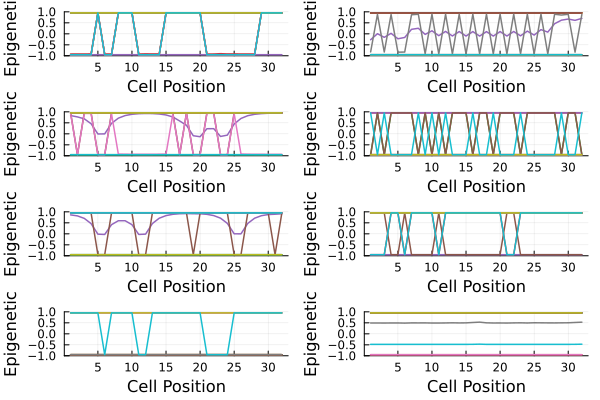

In [57]:
#Short version of it all
ParameterMatrix_Collection, PositionArray_Collection, Counter = Mutating_Network(N,M,K,ParameterMatrix_Collection,PositionArray_Collection, Indices, Counter)

for x=1:N
    #CArray = CArray_Collection[x,:]
    #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
    #PositionArray = PositionArray_Collection[x,:]
    Final_Epigenetic_Factors[x,:,:] = Running_Network(CArray_Collection[x,:],ParameterMatrix_Collection[x,:,:],PositionArray_Collection[x,:])
    
end

Indices = Scoring_Indexes(N,Final_Epigenetic_Factors)
Epi_Plotter(Indices,K,Final_Epigenetic_Factors)

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.2 0.0 0.0 0.0 13.6 0.0 6.4 0.0 0.0 0.0 18.9 0.0 0.0 29.0 0.0 12.5 0.0 14.1 0.0 0.0 0.0 0.0 0.0 0.0 32.2 0.0 0.0 0.0 0.0 0.0 0.0 26.3 0.0 0.0 0.0 0.0 0.0 0.0 54.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.0 0.0 0.0 0.0 0.0 0.0 0.0 15.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 16.5 0.0 0.0 0.0 23.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97

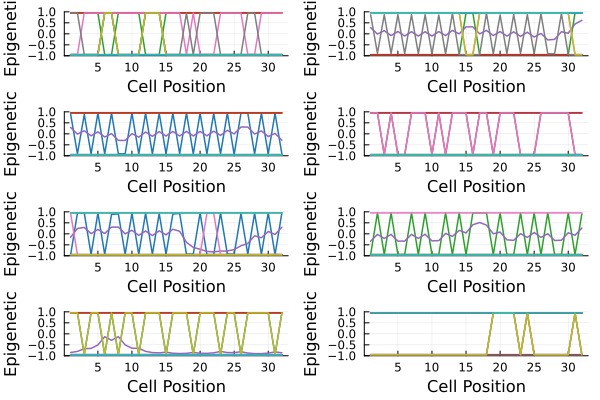

[0.0 1.0 0.0 0.0 21.0 0.0 10.0 0.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 41.8 0.0 0.0 10.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.0 0.0 0.0 0.0 0.0 4.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.0 17.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 58.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 0.0 0.0 0.0 0.0 0.0 27.4 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 30.2 10.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0

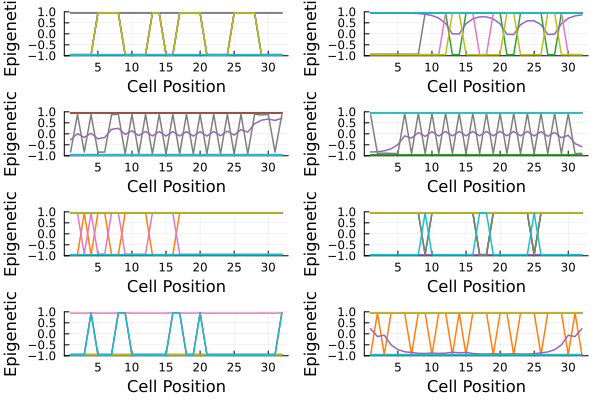

[0.0 0.0 0.0 0.0 0.0 20.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.0 0.0 0.0 22.2 0.0 0.0 14.5 0.0 0.0 6.4 0.0 0.0 13.5 0.0 12.4 27.2 0.0 0.0 0.0 11.0 0.0 10.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.6 14.0 48.0 0.0 0.0 26.3 0.0 0.0 0.0 12.0 0.0 33.2 0.0 0.0 0.0 6.4 0.0 0.0 0.0 20.0 33.4 0.0 0.0 0.0 0.0 21.0 11.0 0.0 0.0 0.0 13.1 0.0 0.0 29.7 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.5 14.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.5 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0

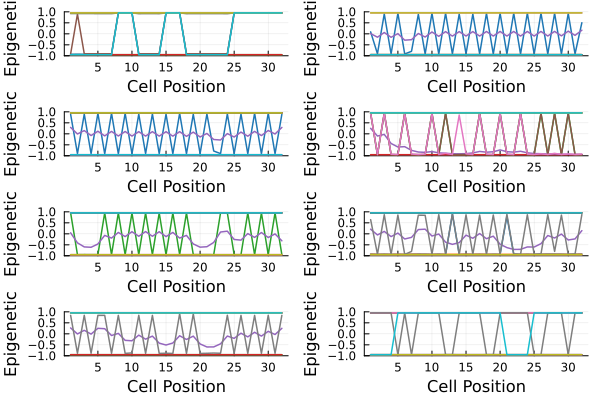

[0.0 0.0 0.0 0.0 0.0 12.0 0.0 0.0 0.0 0.0 31.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 31.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.5 0.0 0.0 0.0 0.0 0.0 0.0 9.0 0.0 11.0 0.0 0.0 0.0 3.2 0.0 0.0 0.0 0.0 11.0 0.0 24.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 46.8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 25.9 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 9

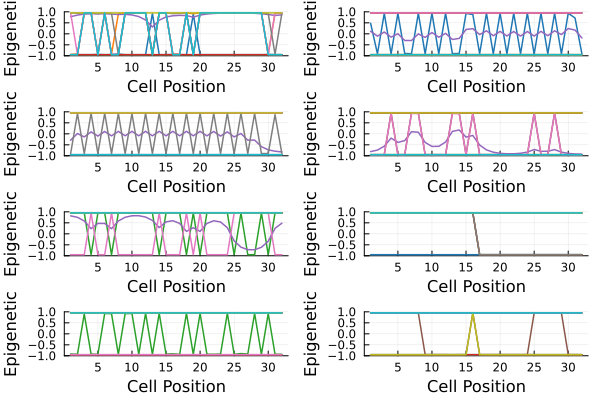

[0.0 0.0 6.4 0.0 0.0 0.0 29.0 0.0 0.0 28.0 0.0 0.0 0.0 0.0 0.0 0.0 15.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 56.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 18.5 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.0 0.0 0.0 0.0 0.0 0.0 0.0 23.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 22.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 27.1 0.0 0.0 0.0 0.0 23.7 0.0 45.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.

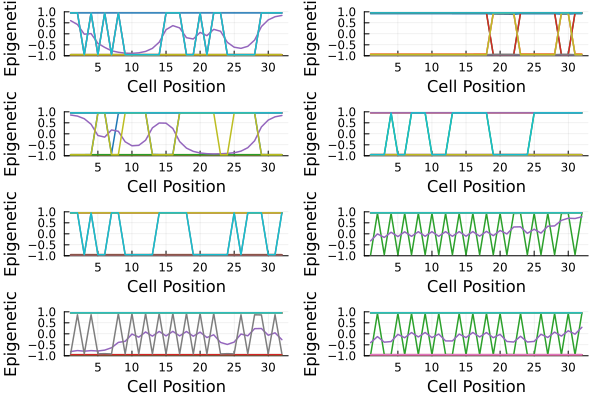

[0.0 0.0 0.0 0.0 6.4 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 14.0 4.0 2.0 0.0 0.0 0.0 0.0 0.0 29.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 13.5 1.5 0.0 0.0 2.0 0.0 0.0 13.5 0.0 45.0 17.6 0.0 1.0 0.0 0.0 0.0 9.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 23.0 17.7 0.0 9.0 0.0 0.0 29.2 0.0 0.0 0.0 31.2 0.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 6.4 0.0 0.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 

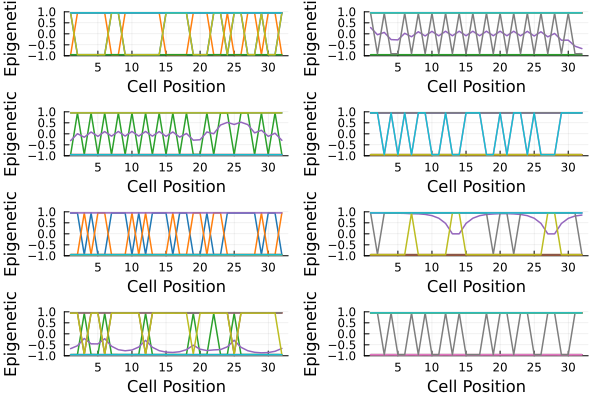

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 30.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 20.5 0.0 0.0 0.0 0.0 0.0 10.5 0.0 0.0 20.0 0.0 0.0 0.0 0.0 14.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.0 0.0 0.0 0.0 29.1 0.0 39.0 0.0 27.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.0 0.0 0.0 26.5 0.0 0.0 34.2 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 14.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 23.0 0.0 0.0 0.0 5.0 0.0 0.0 28.2 0.0 0.0 11.9 0.0 18.2 8.0 54.3 0.0 0.0 0.0 10.0 0.0 0.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96

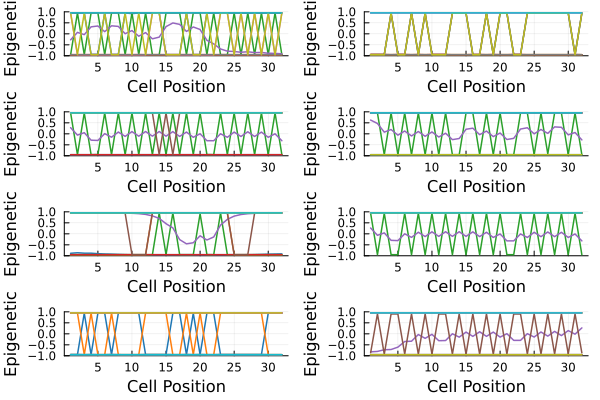

[0.0 0.0 0.0 0.0 0.0 0.0 31.2 31.5 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 27.2 0.0 21.4 0.0 0.0 5.0 0.0 0.0 47.9 0.0 0.0 1.0 0.0 0.0 21.1 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 55.0 26.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 13.2 0.0 0.0 0.0 5.5 0.0 6.4 0.0 24.2 0.0 31.2 0.0 0.0 28.8 20.0 34.5 0.0 0.0 0.0 0.0 0.0 0.0 18.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.1 0.0 6.4 0.0 0.0 52.5 0.0 0.0 0.0 0.0 0.0 25.5 0.0 0.0 0.0 0.0 0.0 0.0 23.0 0.0 0.0 0.0 0.0 0.0 6.0 0.0 0.0 0.0 39.4 0.0 9.9 9.0 0.0 0.0 0.0 6.4 0.0 0.0 0.0 0.0 0.0 11.0 0.0; 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 

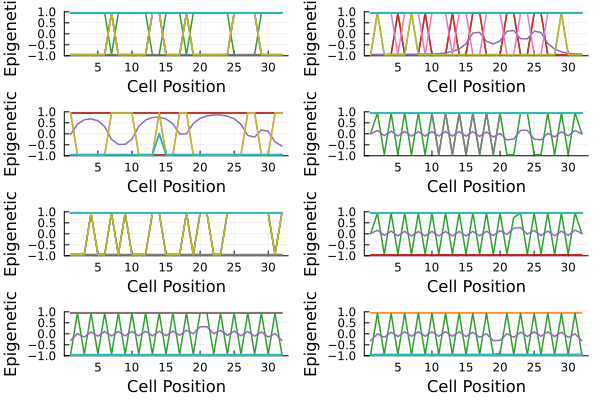

In [58]:
for q=1:8
    #Short version of it all
    ParameterMatrix_Collection, PositionArray_Collection, Counter = Mutating_Network(N,M,K,ParameterMatrix_Collection,PositionArray_Collection, Indices, Counter)

    for x=1:N
        #CArray = CArray_Collection[x,:]
        #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
        #PositionArray = PositionArray_Collection[x,:]
        Final_Epigenetic_Factors[x,:,:] = Running_Network(CArray_Collection[x,:],ParameterMatrix_Collection[x,:,:],PositionArray_Collection[x,:])

    end

    Indices = Scoring_Indexes(N,Final_Epigenetic_Factors)
    Figure = Epi_Plotter(Indices,K,Final_Epigenetic_Factors)
    display(Figure)
    sleep(1)
end